# Evaluation for Synthetic Data

In [3]:
# import packages
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr
import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

## Data Preparation

In [1]:
# specify numerical columns
num_cols = ['ab_pain_dur', 'age', 'aneroxia_dur', 'plasmodium_density',
               'cough_dur', 'diarrhea_dur', 'fatigue_dur', 'fever_dur', 'headache_dur',
               'height', 'hemoglobin', 'joint_pain_dur', 'muscle_ache_dur', 'temp',
               'vomit_dur', 'weight', 'dday', 'first_dday']

# specify categorical columns
cat_cols = ['complicated_malaria_no',
    'complicated_malaria_not_assessed', 'complicated_malaria_yes',
    'febrile_no', 'febrile_yes', 'ITN_no', 'ITN_not_applicable', 'ITN_yes',
    'malaria_no', 'malaria_yes',
    'malaria_parasite_blood_smear_indicated_but_not_done',
    'malaria_parasite_blood_smear_negative_/_lamp_negative',
    'malaria_parasite_blood_smear_negative_/_lamp_not_done',
    'malaria_parasite_blood_smear_negative_/_lamp_positive',
    'malaria_parasite_blood_smear_not_indicated',
    'malaria_parasite_blood_smear_positive_/_no_malaria',
    'malaria_parasite_symptomatic_malaria',
    'malaria_treatment_artmether-lumefantrine_for_uncomplicated_malaria',
    'malaria_treatment_no_malaria_medications_given',
    'malaria_treatment_quinine_for_uncomplicated_malaria_in_the_1st_trimester_of_pregnancy',
    'malaria_treatment_quinine_for_uncomplicated_malaria_within_14_days_of_a_previous_treatment_for_malaria',
    'malaria_treatment_quinine_or_artesunate_for_complicated_malaria',
    'plasmodium_gametocytes_no', 'plasmodium_gametocytes_yes',
    'plasmodium_lamp_negative', 'plasmodium_lamp_no_result',
    'plasmodium_lamp_positive', 'visit_type_enrollment',
    'visit_type_scheduled_visit', 'visit_type_unscheduled_visit']

def get_numerical_columns_df(df, num_cols=num_cols, return_id=False):
    """
    takes in dataframe with various columns and returns dataframe with only numerical columns
    ** to use with dataset other than prism dataset, please specify your own columns

    Args:
    df: dataframe converted from npy arrays generated by doppelganger
    num_cols: list of names of the numerical columns

    Returns:
    df_num: dataframe with only numerical columns
    """

    if return_id:
        num_cols = ['id'] + num_cols

    df_num = df[num_cols].copy()
    return df_num

def get_categorical_columns_df(df, cat_cols=cat_cols, return_id=False):
    """
    takes in dataframe with various columns and returns dataframe with only categorical columns
    ** to use with dataset other than prism dataset, please specify your own columns

    Args:
    df: dataframe converted from npy arrays generated by doppelganger
    cat_cols: list of names of the categorical columns

    Returns:
    df_num: dataframe with only categorical columns
    """

    if return_id:
        cat_cols = ['id'] + cat_cols
    df_cat = df[cat_cols].copy()
    return df_cat

In [2]:
def Stack2DSequence(df, time_seq_len=130):
    '''
    Transform a df in 2D shape into 3D by putting the data for the sampe patient ('id') in each layer, the 
    resulting shape is (no. of sample, max(time_sequence),dimension of column). If the time sequence length
    of this patient is less than the max(time_sequence), then post-pad remaining rows as zero.
    Args:
    df: dataframe with 'id' column as the first column
    time_seq_len = maximum time series length

    Returns:
    stacked_array: df reshaped into array of shape (num sample, time_seq_len, dim_columns)
    '''
    stacked_array = []
    id_unique = df.id.unique()

    for i in id_unique:
        child = np.array(df.loc[df['id'] == i].iloc[:, 1:])
        child = np.pad(child, ((0, time_seq_len-len(child)), (0,0)))
        stacked_array.append(child)
    stacked_array = np.stack(stacked_array)
    return stacked_array


In [4]:
# load in original and generated (intermediate) csv
ori = pd.read_csv('data_attr/ori_prism_cleaned.csv')
gen = pd.read_csv('data_attr/gen_prism_int_e200.csv')

# get numerical and categorical columns for original and generated data
ori_num = get_numerical_columns_df(ori)
gen_num = get_numerical_columns_df(gen)
ori_cat = get_categorical_columns_df(ori)
gen_cat = get_categorical_columns_df(gen)

# turn dataframe into 3D np arrays (both cat and num data)
ori_3d = Stack2DSequence(ori) #shape (1347,130,48)
gen_3d = Stack2DSequence(gen) #shape (1347,130,48)

# turn dataframe into 3D np arrays of only numerical or categorical data
ori_3d_num = Stack2DSequence(get_numerical_columns_df(ori, return_id=True))
gen_3d_num = Stack2DSequence(get_numerical_columns_df(gen, return_id=True))
ori_3d_cat = Stack2DSequence(get_categorical_columns_df(ori, return_id=True))
gen_3d_cat = Stack2DSequence(get_categorical_columns_df(gen, return_id=True))

In [5]:
# create a dictionary for the case where we want to loop through multiple sets of real and gen data
synthetic_data_dic = {'DoppelGANger_0903':[ori, gen]}
synthetic_num_dic = {'DoppelGANger_0903':[ori_num, gen_num]}
synthetic_cat_dic = {'DoppelGANger_0903':[ori_cat, gen_cat]}
synthetic_array_dic = {'DoppelGANger_0903':[ori_3d, gen_3d]}
synthetic_array_num_dic = {'DoppelGANger_0903':[ori_3d_num, gen_3d_num]}
synthetic_array_cat_dic = {'DoppelGANger_0903':[ori_3d_cat, gen_3d_cat]}
syn_keys = list(synthetic_data_dic.keys())
n = len(syn_keys)


## 1. Distribution 

### 1.1 Histogram for each numerical column

In [6]:
def Histogram_KSTest(ori_nozero, gen_nozero, syn_name, size=100):
    """
    draws the pdf and cdf of numerical columns in original and generated data
    computes the KS Test value for ori and gen data
    K-S test result returns stats, p_value
    Ideally p_value should be as large as possible

    Args:
    ori_nonzero: original data with rows containing zeroes removed in dataframe format
    gen_nonzero: generated data with rows containing zeroes removed in dataframe format
    syn_name: version of synthetic data (used for labelling) e.g. 'doppelganger1'

    Returns:
    p_series: p_value for each numerical column in dataframe
    """
    keys = (ori_nozero.keys()).tolist()
    n = len(keys)
    l = min(len(ori_nozero),len(gen_nozero))
    
    p_value = np.zeros(n)
    for num in range(n):
        name = keys[num]
        ser_ori = ori_nozero[name].values[:l]
        ser_gen = gen_nozero[name].values[:l]
        df= pd.DataFrame({'ori':ser_ori, 'gen':ser_gen})
        df.plot.hist(bins=100,alpha=0.5,cumulative=False)
        plt.title(syn_name+' '+name+'_pdf')
        df.plot.hist(bins=100,alpha=0.5,cumulative=True,histtype='step')
        plt.title(syn_name+' '+name+'_cdf')
        plt.show()

        value = [0,0]
        for k in range(10):
        #Randomly take 100 samples from the generated and real data, since the total sample size is 40,000+, which is too
        #large and the null hypothesis can get easily rejected, which actually doesn't make statistical sense.
            idx = np.random.permutation(l)
            idx = idx[:size]
            name = keys[num]
            ser_ori = ori_nozero[name].values[idx]
            ser_gen = gen_nozero[name].values[idx]
            (t,p) = stats.ks_2samp(ser_ori, ser_gen)
            value[0] = value[0]+t
            value[1] = value[1]+p
        value = np.array(value)/10
        p_value[num] = value[1]
        print('K-S test result:',value) #the displayed array is the average (statistic, p_value), the closer to 0 the p is
        #the null hypothesis is more likely to be rejected.
    p_series = pd.Series(p_value, index = keys)
    return p_series

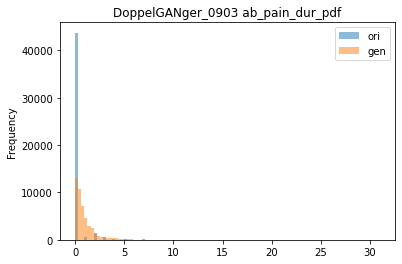

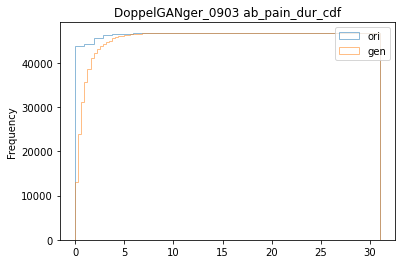

K-S test result: [9.3500000e-01 9.9431464e-44]


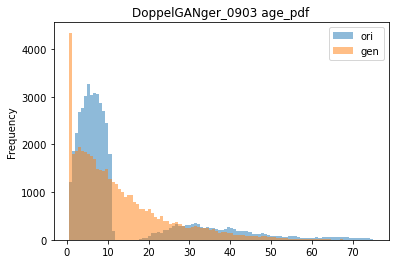

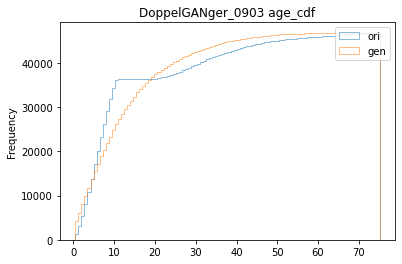

K-S test result: [0.231      0.02966718]


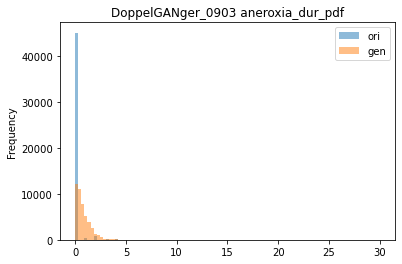

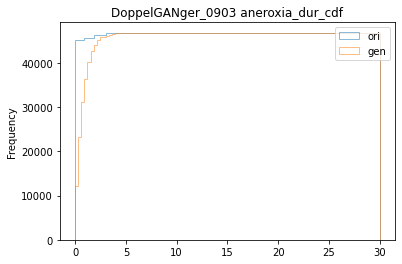

K-S test result: [9.6400000e-01 1.8805899e-49]


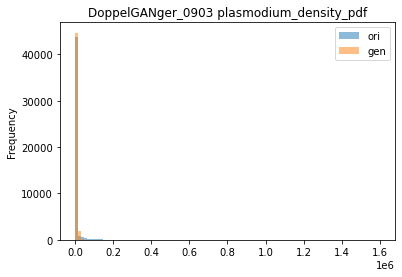

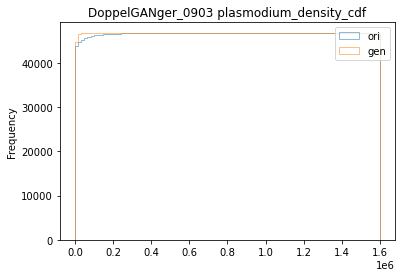

K-S test result: [8.28000000e-01 1.95542237e-30]


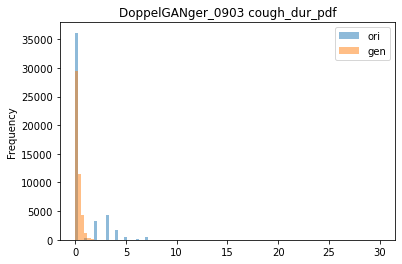

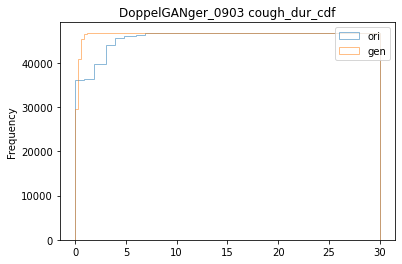

K-S test result: [5.25000000e-01 6.62661183e-09]


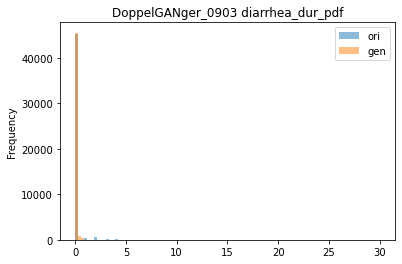

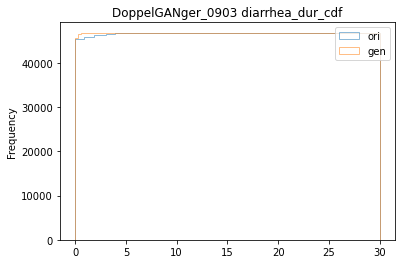

K-S test result: [5.96000000e-01 3.56436787e-14]


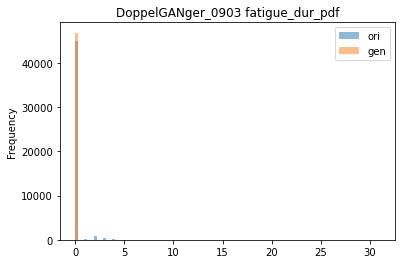

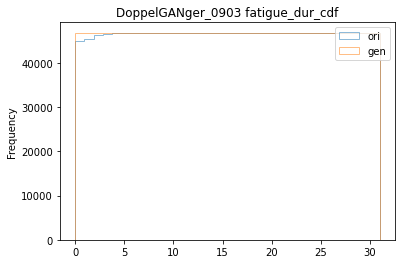

K-S test result: [8.74000000e-01 4.04949251e-36]


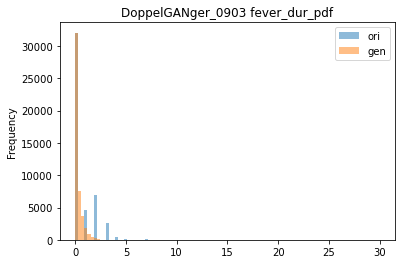

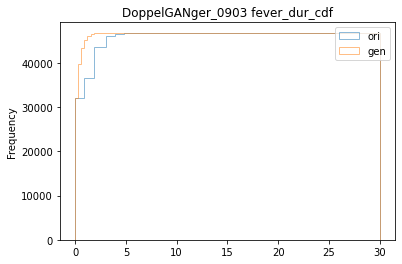

K-S test result: [0.322      0.00113011]


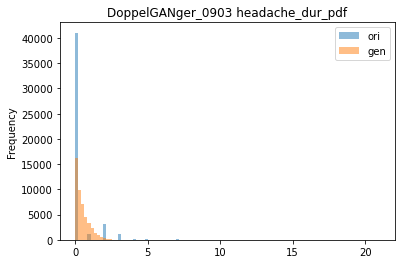

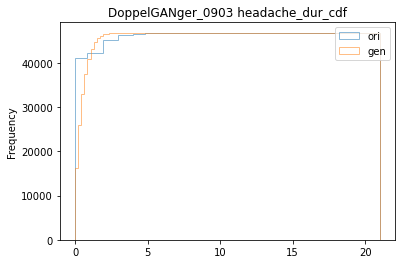

K-S test result: [8.61000000e-01 3.05940138e-32]


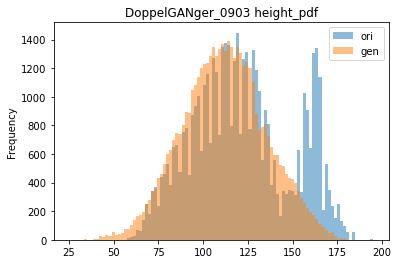

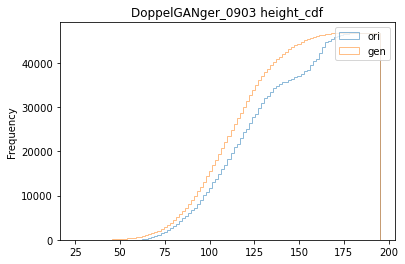

K-S test result: [0.21       0.09464709]


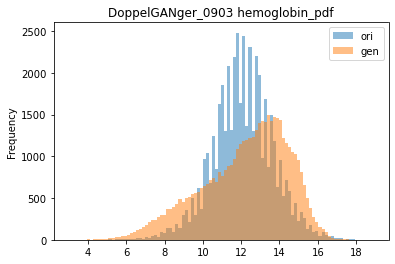

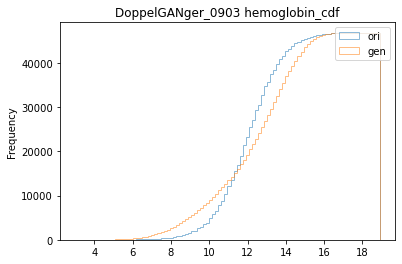

K-S test result: [0.217    0.052618]


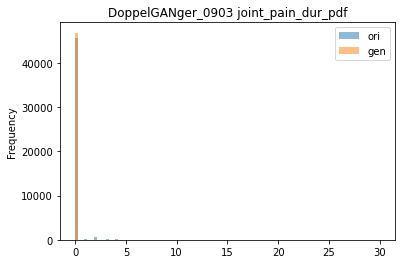

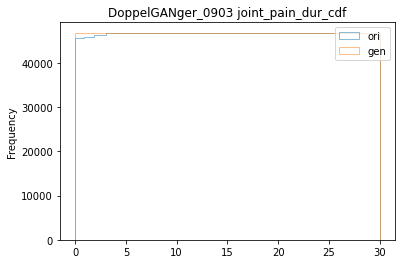

K-S test result: [0.027      0.99999965]


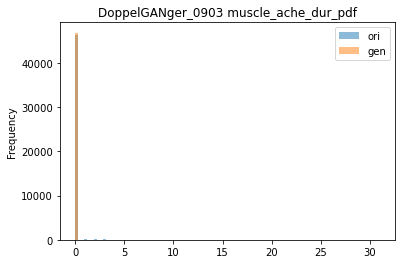

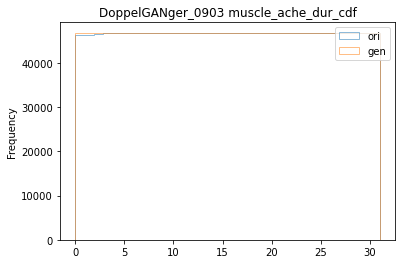

K-S test result: [0.013      0.99999988]


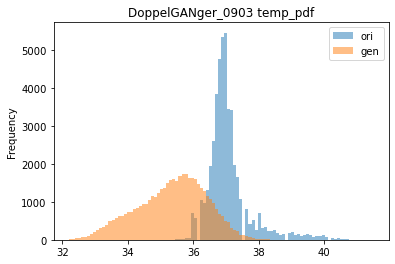

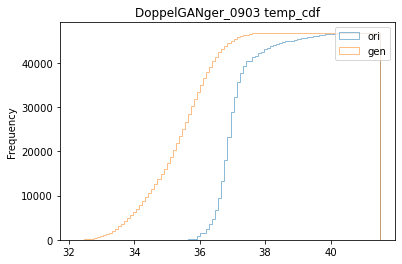

K-S test result: [8.01000000e-01 1.58752934e-25]


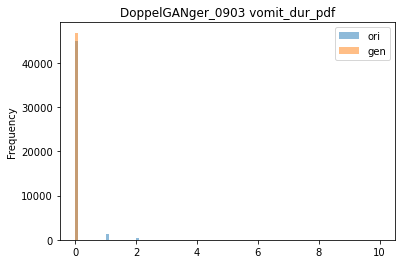

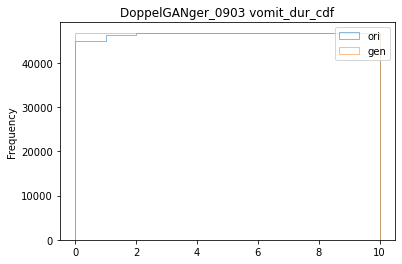

K-S test result: [0.076      0.85931062]


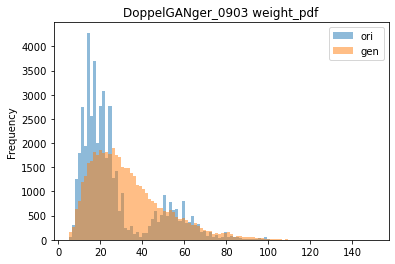

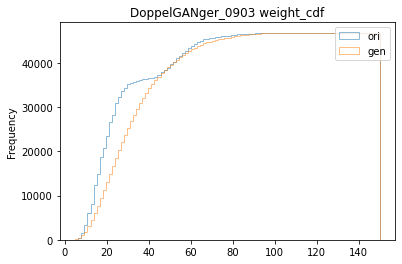

K-S test result: [0.273      0.00961862]


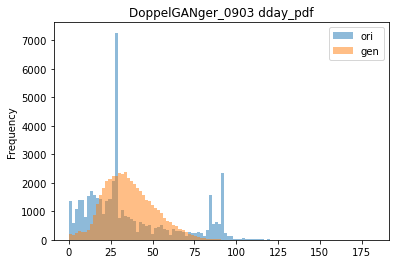

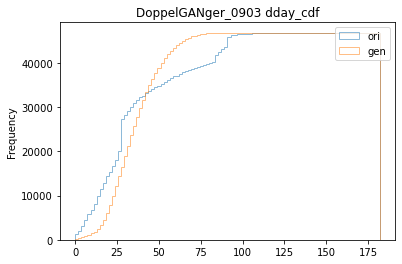

K-S test result: [0.271      0.01195928]


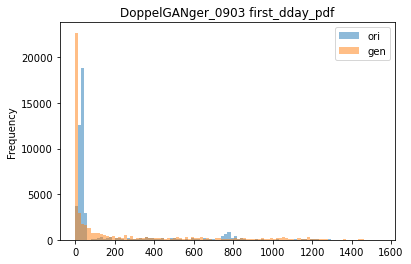

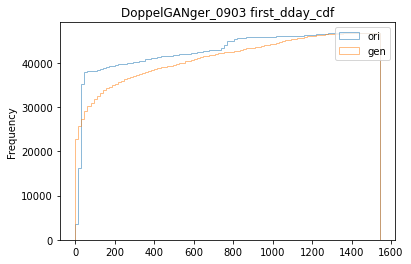

K-S test result: [4.68000000e-01 9.70248081e-08]


In [9]:
#Implement with all synthetic data and the corresponding real data.
for i in range(n):
    key = syn_keys[i]
    p_series = Histogram_KSTest(synthetic_num_dic[key][0],synthetic_num_dic[key][1],syn_name = key)
    if i == 0:
        p_df = pd.DataFrame(p_series,columns = [key])
    else:
        p_df = pd.concat([p_df,pd.DataFrame(p_series,columns = [key])],axis=1,sort = False)

In [10]:
pd.set_option('display.float_format', lambda x: '%.7f' % x)
#p_df.to_csv('csv_results/1.1 Distribution/p_value_table.csv')
display('p value table',p_df)


'p value table'

DoppelGANger_0903
ab_pain_dur                 0.0000000
age                         0.0296672
aneroxia_dur                0.0000000
plasmodium_density          0.0000000
cough_dur                   0.0000000
diarrhea_dur                0.0000000
fatigue_dur                 0.0000000
fever_dur                   0.0011301
headache_dur                0.0000000
height                      0.0946471
hemoglobin                  0.0526180
joint_pain_dur              0.9999996
muscle_ache_dur             0.9999999
temp                        0.0000000
vomit_dur                   0.8593106
weight                      0.0096186
dday                        0.0119593
first_dday                  0.0000001

### 1.2 Scatter plot for categorical columns

In [11]:
def Scatter_Distance(ori_data, gen_data, syn_name = None):
    """
    Plots the proportion of 1s and 0s in each categorical column in the synthetic data against the real data.
    An ideal synthetic data should lie on the diagonal y=x.
    Calculates the average distance of points plotted to the line y=x.
    The smaller the average distance, the better.

    Args:
    ori_data: original data with only categorical columns in dataframe format
    gen_data: generated data with only categorical columns in dataframe format
    syn_name: version of synthetic data (used for labelling) e.g. 'doppelganger

    Returns:
    distance: average distance of points plotted to line y=x
    """

    import matplotlib.pyplot as plt
    from math import sqrt
    
    def CatProportion(series):
        return series.value_counts()/len(series)

    cat_keys = (gen_data.keys()).tolist()
    first = True
    name_index = []
    cat_index = []
    for name in cat_keys:
        df_1=pd.DataFrame({'gen':CatProportion(gen_data[name]),'ori': CatProportion(ori_data[name])})
        if first:
            v = df_1.values
            first = False
        else:
            v = np.concatenate((v,df_1.values),axis = 0)
        df1_index = df_1.index.tolist()
        name_index += [name]*len(df1_index)
        cat_index += df1_index
    
    df_cat = pd.DataFrame(v, index = [name_index,cat_index], columns = [syn_name+ ' '+'generated',syn_name+' '+'original'])
    df_cat = df_cat.fillna(0)
    display(df_cat)
    #df_cat.to_csv('csv_results/1.1 Distribution/ '+syn_name+'categorical scatter.csv')
    plt.scatter(df_cat[syn_name+ ' '+'generated'],df_cat[syn_name+' '+'original'],c = 'r')
    plt.plot([0,1])
    plt.show()
    
    def PtToDiagnalDist(coordinates, aver = True):
        '''
        For a series of points(2D), calculate the distance between each points and the diagonal y=x
        
        Args: 
        coordinates: array in shape (n,2), n is the number of points
        aver: True(default) or False. If aver == True, the distances are averaged, otherwise a list of distances is returned
        
        Returns:
        a: a list of distances, returned when aver==False
        np.sum(a)/n: the average of distances, returned when aver == True
        '''
        n = len(coordinates)
        a = np.zeros(n)
        for i in range(n):
            x = coordinates[i][0]
            y = coordinates[i][1]
            d = abs(x-y)/sqrt(2) #formula to calculate the distance between point (X,Y) and line ax+by+c = 0 is
            # abs(aX+bY+c)/abs(a^2+b^2)
            a[i]=d
        if aver:
            return np.sum(a)/n
        else:
            return a

    distance = PtToDiagnalDist(df_cat.values)
    return distance

DoppelGANger_0903 generated  \
complicated_malaria_no                             0.0000000                    0.9787571   
                                                   1.0000000                    0.0212429   
complicated_malaria_not_assessed                   1.0000000                    0.9787571   
                                                   0.0000000                    0.0212429   
complicated_malaria_yes                            0.0000000                    1.0000000   
                                                   1.0000000                    0.0000000   
febrile_no                                         1.0000000                    0.7887032   
                                                   0.0000000                    0.2112968   
febrile_yes                                        0.0000000                    0.7887032   
                                                   1.0000000                    0.2112968   
ITN_no                                             0.0000000                    1.0000000   
                                                   1.0000000                    0.0000000   
ITN_not_applicable                                 0.0000000                    0.9712130   
                                                   1.0000000                    0.0287870   
ITN_yes                                            1.0000000                    0.9712130   
                                                   0.0000000                    0.0287870   
malaria_no                                         1.0000000                    0.9772183   
                                                   0.0000000                    0.0227817   
malaria_yes                                        0.0000000                    0.9772183   
                                                   1.0000000                    0.0227817   
malaria_parasite_blood_smear_indicated_but_not_... 0.0000000                    1.0000000   
                                                   1.0000000                    0.0000000   
malaria_parasite_blood_smear_negative_/_lamp_ne... 0.0000000                    0.5067319   
                                                   1.0000000                    0.4932681   
malaria_parasite_blood_smear_negative_/_lamp_no... 0.0000000                    0.6607967   
                                                   1.0000000                    0.3392033   
malaria_parasite_blood_smear_negative_/_lamp_po... 0.0000000                    0.9793554   
                                                   1.0000000                    0.0206446   
malaria_parasite_blood_smear_not_indicated         0.0000000                    0.9692469   
                                                   1.0000000                    0.0307531   
malaria_parasite_blood_smear_positive_/_no_malaria 0.0000000                    0.9978415   
                                                   1.0000000                    0.0021585   
malaria_parasite_symptomatic_malaria               0.0000000                    0.8860275   
                                                   1.0000000                    0.1139725   
malaria_treatment_artmether-lumefantrine_for_un... 0.0000000                    0.9764917   
                                                   1.0000000                    0.0235083   
malaria_treatment_no_malaria_medications_given     1.0000000                    0.9764917   
                                                   0.0000000                    0.0235083   
malaria_treatment_quinine_for_uncomplicated_mal... 0.0000000                    1.0000000   
                                                   1.0000000                    0.0000000   
malaria_treatment_quinine_for_uncomplicated_mal... 0.0000000                    1.0000000   
                                                   1.0000000                    0.0000000   
malaria_treatment_quinine_or_artesunate_for_com... 0.0000000   

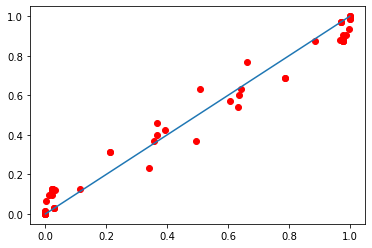

'average distance to the diagonal'

DoppelGANger_0903   0.0369463
dtype: float64

In [12]:
#Implement with all synthetic data and the corresponding real data.
d_array = np.zeros(n)
for i in range(n):
    key = syn_keys[i]
    distance = Scatter_Distance(synthetic_cat_dic[key][0],synthetic_cat_dic[key][1],syn_name = key)
    d_array[i] = distance
distance_series= pd.Series(d_array,index = syn_keys)
#distance_series.to_csv('csv_results/1.1 Distribution/aver_distance_to_the_diag.csv')
display('average distance to the diagonal', distance_series)

### 1.3 Pearson's Correlation Coefficient Comparison

In [6]:
def r_corr_test(df,PTable = False, CoefficientandPtable = False, lower = True ):
    '''Returns a table of Pearson's r correlation coefficients between every pair of columns in the dataframe
    
    Args:
    df: The input dataframe
    PTable: False (default) or True, if True, then the return is a table containing the p(probavility)-value of correlation test.
    CoefficientandPtable: False(default) or True, if true, then the return is a table containing tuples (p-value, r coefficient) from the correlation test.
    lower: True(default) or False. If True, the lower triangle part of the table is filled with the transpose of the upper triangle part rather than leaved with None.
    
    Returns:
    The requested table as specified in the args. If PTable and CoefficientandPtable are all False, then the return table consists of coefficient values only.
    
    '''

    df_index = (df.keys()).tolist()
    n = len(df_index)
    ini = [ [ None for y in range( n ) ] 
                 for x in range( n ) ]

    #pearsonr returns two values: the correlation coefficient and significance test probability p
    #so we create two empty dataframes to store them
    coefficient_table = pd.DataFrame(ini,index = df_index,columns = df_index)
    p_table = coefficient_table.copy()
    coe_and_p_table = coefficient_table.copy()

    for i in range(n):
        for j in range(i+1,n):
            name1 = df_index[i]
            name2 = df_index[j]
            obs_1 = df[name1].dropna()
            obs_2 = df[name2].dropna()
            dataframe = pd.DataFrame({name1: obs_1, name2: obs_2})

            values = dataframe.dropna().values
            (coe,p) = pearsonr(values[:,0],values[:,1])
            coefficient_table.loc[name1,name2]=coe
            p_table.loc[name1,name2]=p
            coe_and_p_table.loc[name1,name2]=(coe,p)
    
    if lower:
        #A function that can fill the lower part of the dataframe, because coe_table and p_table has their lower triangles empty
        #But for comparison reasons you may want them to be filled
        def fill_lower(df):
            n = df.values.shape[0]
            for j in range(n):
                for i in range(j+1,n):
                    df.iloc[i,j]=df.iloc[j,i]
            return df
        
        coefficient_table = fill_lower(coefficient_table)
        p_table = fill_lower(p_table)
        coe_and_p_table = fill_lower(coe_and_p_table)
    
    
    if PTable:
        return p_table
    elif CoefficientandPtable:
        return coe_and_p_table
    else:
        return coefficient_table

#### SRA

In [7]:
def SRA(R,S):
    '''Calculate the SRA of lists R and S
    
    Args:
    - R: A list of performance metrics of different predictive models from TSTS
    - S: A list of performance metrics of different predictive models from TRTR, len(S)=len(R)
    
    Returns:
    - SRA: SRA value
    
    '''
    def identity_function(statement):
        v = 0
        if statement:
            v = 1
        return v
            
    k = min(len(R), len(S)) #technically should be same
    sum_ = 0
    for i in range(k):
        for j in range(k):
            if i != j:
                if (R[i]-R[j])==0:
                    if (S[i]-S[j])==0:
                        agree = True
                    else:
                        agree = False
                else:
                    agree = (R[i]-R[j])*(S[i]-S[j])>0
                sum_ += identity_function(agree)
    SRA = sum_ / (k*(k-1))
    return SRA

In [8]:
def CorrelationSRA(ori_correlation_df,gen_correlation_df,ColumnWise = False):
    '''Returns the value of SRA for the absolute Pearsons correlation coefficients for each column between 
    all other columns. SRA is between 0 and 1, the closer the SRA is to 1, the more the agreement between the ranking,
    the more similar the synthetic data and the real data are.
    
    Args:
    ori_correlation_df: the correlation coefficient dataframe for the real data, usually generated from the function 
                        r_corr_test.
    gen_correlation_df: the correlation coefficient dataframe for the synthetic data, usually generated from the function 
                        r_corr_test. 
    ColumnWise: False(default) or True. If True, the return is a Series containing the SRA value for each column and the average.
                Otherwise, the return is the average of SRA values for all columns
    
    Returns:
    s: It is either a column-wise SRA series or the average SRA values of them, determined by the arg ColumnWise.
    
    '''
    
    columns = (ori_correlation_df.keys()).tolist()
    n = len(columns)
    ini = np.ones(n)
    
    for i in range(n):
        ori_values = ori_correlation_df.iloc[i,:].fillna(-1)
        gen_values = gen_correlation_df.iloc[i,:].fillna(-1) #quick fix when len(R) != len(S) due to a particular column having all zeroes, hence r_corr_test returns NAN values, the fillna above was originally dropna(), resulting that column to be dropped and creating trouble in CorrelationSRA as len(R) != len(S) anymore, hence index out of bound when looping
        ini[i] = SRA(abs(ori_values), abs(gen_values))
    
    if ColumnWise:
        s = pd.Series(ini,index = columns)
        s['average'] = sum(ini)/n
    else:
        s = sum(ini)/n
    return s

In [9]:
def MSE(r_table_ori,r_table_gen):
    '''
    Returns the MSE for each position between two dataframes and an average value.
    '''
    import pandas as pd
    import numpy as np
    ori = r_table_ori.fillna(0).values
    gen = r_table_gen.fillna(0).values
    columns = (r_table_gen.keys()).tolist()
    matrix = (ori-gen)**2
    df = pd.DataFrame(matrix, index = columns, columns = columns)
    score = np.sum(matrix)/(len(ori)*(len(ori)-1)) #The diagonal is always zero so we don't count them
    return df, score

In [19]:
n = len(syn_keys)
MSE_array = np.zeros(n)
for i in range(n):
    key = syn_keys[i]
    df_ori = synthetic_data_dic[key][0]
    df_gen = synthetic_data_dic[key][1]
    r_table_ori = r_corr_test(df_ori)
    r_table_gen = r_corr_test(df_gen)
    
    #Highlight all r values > 0.5 as yellow, indicating strong correlation
    def color_threshold_yellow(val):
        threshold = 0.5
        if ((val != None) and (abs(val) > threshold)):
            color = 'yellow' 
        else:
            color = 'black'
        return 'color: %s' % color

    display(key+' '+'generated r table',r_table_gen.style.applymap(color_threshold_yellow))
    display(key+' '+'real r table',r_table_ori.style.applymap(color_threshold_yellow))
    sra = CorrelationSRA(r_table_ori,r_table_gen,ColumnWise=True)
    if i==0:
        sra_df = pd.DataFrame(sra,columns = [key])
    else:
        sra_df = pd.concat([sra_df,pd.DataFrame(sra,columns = [key])], axis = 1, sort = False)
    display(key+' '+'SRA',sra)
    MSE_df, MSE_score = MSE(r_table_gen,r_table_ori)
    display(key+' '+'MSE table', MSE_df)
    MSE_array[i] = MSE_score
MSE_series = pd.Series(MSE_array,index = syn_keys)

'DoppelGANger_0903 generated r table'

'DoppelGANger_0903 real r table'

'DoppelGANger_0903 SRA'

id                                                                                                       0.3894558
ab_pain_dur                                                                                              0.4515306
age                                                                                                      0.5680272
aneroxia_dur                                                                                             0.4795918
plasmodium_density                                                                                       0.4727891
cough_dur                                                                                                0.5102041
diarrhea_dur                                                                                             0.3962585
fatigue_dur                                                                                              0.4863946
fever_dur                                                                       

'DoppelGANger_0903 MSE table'

id  ab_pain_dur  \
id                                                 0.0000000    0.0000429   
ab_pain_dur                                        0.0000429    0.0000000   
age                                                0.0002264    0.0128281   
aneroxia_dur                                       0.0094825    0.0000349   
plasmodium_density                                 0.0000213    0.0840074   
cough_dur                                          0.0126800    0.0686624   
diarrhea_dur                                       0.0204755    0.1145833   
fatigue_dur                                        0.0001130    0.0005085   
fever_dur                                          0.0142094    0.0927941   
headache_dur                                       0.0000266    0.0013007   
height                                             0.0088373    0.0149329   
hemoglobin                                         0.0101860    0.0157665   
joint_pain_dur                                     0.0000058    0.0077327   
muscle_ache_dur                                    0.0003981    0.0081973   
temp                                               0.0018350    0.0011041   
vomit_dur                                          0.0033010    0.0323774   
weight                                             0.0126108    0.0113114   
complicated_malaria_no                             0.0108234    0.0026348   
complicated_malaria_not_assessed                   0.0104937    0.0025705   
complicated_malaria_yes                            0.0000603    0.0000110   
febrile_no                                         0.0083341    0.0093812   
febrile_yes                                        0.0083341    0.0093812   
ITN_no                                             0.0000697    0.0000192   
ITN_not_applicable                                 0.0016525    0.0000741   
ITN_yes                                            0.0017269    0.0000473   
malaria_no                                         0.0106387    0.0024897   
malaria_yes                                        0.0106387    0.0024897   
malaria_parasite_blood_smear_indicated_but_not_... 0.0000064    0.0000015   
malaria_parasite_blood_smear_negative_/_lamp_ne... 0.0114303    0.0144193   
malaria_parasite_blood_smear_negative_/_lamp_no... 0.0039730    0.0008862   
malaria_parasite_blood_smear_negative_/_lamp_po... 0.0071665    0.0012594   
malaria_parasite_blood_smear_not_indicated         0.0001514    0.0297427   
malaria_parasite_blood_smear_positive_/_no_malaria 0.0087814    0.0023385   
malaria_parasite_symptomatic_malaria               0.0096930    0.0025131   
malaria_treatment_artmether-lumefantrine_for_un... 0.0096716    0.0027244   
malaria_treatment_no_malaria_medications_given     0.0094416    0.0027315   
malaria_treatment_quinine_for_uncomplicated_mal... 0.0000023    0.0001300   
malaria_treatment_quinine_for_uncomplicated_mal... 0.0000939    0.0000160   
malaria_treatment_quinine_or_artesunate_for_com... 0.0000603    0.0000110   
plasmodium_gametocytes_no                          0.0014053    0.0005341   
plasmodium_gametocytes_yes                         0.0014053    0.0005341   
plasmodium_lamp_negative                           0.0120349    0.0101118   
plasmodium_lamp_no_result                          0.0029840    0.0145776   
plasmodium_lamp_positive                           0.0074716    0.0011706   
visit_type_enrollment                              0.0016525    0.0000741   
visit_type_scheduled_visit                         0.0023388    0.0322637   
visit_type_unscheduled_visit                       0.0039052    0.0338984   
dday                                               0.0651535    0.0031129   
first_dday                                         0.0285740    0.0186011   

                                                         age  aneroxia_dur  \
id                                                 0.0002264     0.0094825   
ab_pain_dur                                        

## 2. Fidelity

### 2.1 PCA and tSNE

In [43]:
def visualization (ori_data, generated_data, analysis,syn_name):
    """Using PCA or tSNE for generated and original data visualization.
    (Originally from tGAN code, updated by Aisha to allow ori_data and generated_data to have different time_sequence_length)

    Args:
    - ori_data: original data
    - generated_data: generated synthetic data
    - analysis: tsne or pca
    - syn_name: the name of the synthetic generator
    """  
    # Analysis sample size (for faster computation)
    anal_sample_no = min([1000, len(ori_data),len(generated_data)])
    idx = np.random.permutation(len(ori_data))[:anal_sample_no]

    # Data preprocessing
    ori_data = np.asarray(ori_data)
    generated_data = np.asarray(generated_data)  

    ori_data = ori_data[idx]
    generated_data = generated_data[idx]

    def SameTimeSeq(ori_data,gen_data):
        #make time_seq_o and time_seq_g of a pair of ori_df and gen_df the same to get tSNE and PCA work; we achieve this
        #by padding zeros to the shorter time_seq df.
        no_o, time_seq_o, d = ori_data.shape
        no_g, time_seq_g, d = gen_data.shape
        time_seq = max(time_seq_o,time_seq_g)
        if time_seq_o != time_seq_g:
            if time_seq_g < time_seq_o:
                padding = np.zeros((no_g,time_seq_o-time_seq_g,d))
                gen_data = np.concatenate((gen_data,padding),axis = 1)
            else:
                padding = np.zeros((no_o,time_seq_g-time_seq_o,d))
                ori_data = np.concatenate((ori_data,padding),axis = 1)
        return ori_data,gen_data,time_seq

    ori_data, generated_data, seq_len = SameTimeSeq(ori_data, generated_data)

    for i in range(anal_sample_no):
        if (i == 0):
          prep_data = np.reshape(np.mean(ori_data[0,:,:], 1), [1,seq_len])
          prep_data_hat = np.reshape(np.mean(generated_data[0,:,:],1), [1,seq_len])
        else:
          prep_data = np.concatenate((prep_data, 
                                      np.reshape(np.mean(ori_data[i,:,:],1), [1,seq_len])))
          prep_data_hat = np.concatenate((prep_data_hat, 
                                          np.reshape(np.mean(generated_data[i,:,:],1), [1,seq_len])))

    # Visualization parameter        
    colors = ["red" for i in range(anal_sample_no)] + ["blue" for i in range(anal_sample_no)]    

    if analysis == 'pca':
        # PCA Analysis
        pca = PCA(n_components = 2)
        pca.fit(prep_data)
        pca_results = pca.transform(prep_data) #PCA coordinates for the real data
        pca_hat_results = pca.transform(prep_data_hat) #PCA coordinates for the synthetic data

        # Plotting
        f, ax = plt.subplots(1)    
        plt.scatter(pca_results[:,0], pca_results[:,1],
                    c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
        plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], 
                    c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")

        ax.legend()  
        plt.title(syn_name+' '+'PCA plot')
        plt.xlabel('x-pca')
        plt.ylabel('y_pca')
        #plt.savefig('png_files/2.1 tsne/'+syn_name+'_pca'+'.png')
        plt.show()

    elif analysis == 'tsne':

        # Do t-SNE Analysis together       
        prep_data_final = np.concatenate((prep_data, prep_data_hat), axis = 0)

        # TSNE anlaysis
        tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
        tsne_results = tsne.fit_transform(prep_data_final) #tSNE coordinates, 
        #for [:anal_sample_no, : ] are the coordinates for the original,
        #for [anal_sample_no: , : ] are the coordinates for the generated

        # Plotting
        f, ax = plt.subplots(1)

        plt.scatter(tsne_results[:anal_sample_no,0], tsne_results[:anal_sample_no,1], 
                    c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
        plt.scatter(tsne_results[anal_sample_no:,0], tsne_results[anal_sample_no:,1], 
                    c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")

        ax.legend()

        plt.title(syn_name+' '+'t-SNE plot')
        plt.xlabel('x-tsne')
        plt.ylabel('y_tsne')
        #plt.savefig('png_files/2.1 tsne/'+syn_name+'_tsne'+'.png')
        plt.show()

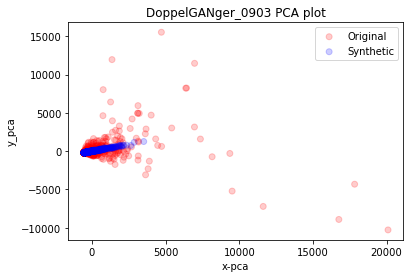

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.090s...
[t-SNE] Computed neighbors for 2000 samples in 1.310s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 18.292664
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.609161
[t-SNE] KL divergence after 300 iterations: 1.005502


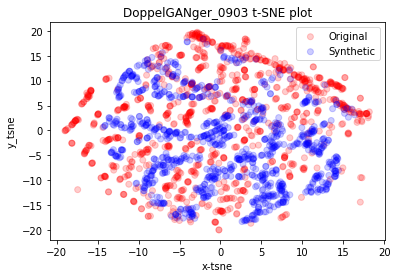

In [44]:
for i in range(n):
    key = syn_keys[i]
    visualization(synthetic_array_dic[key][0], synthetic_array_dic[key][1], 'pca',syn_name = key)
    visualization(synthetic_array_dic[key][0], synthetic_array_dic[key][1], 'tsne',syn_name = key)

### 2.2 Discriminative Model

In [75]:
# Split into train, val, test set
def train_val_test_split(ori_data, gen_data, frac=(0.65, 0.2, 0.15)): 

  data = np.concatenate([ori_data,gen_data],axis=0)
  labels = np.concatenate([np.ones(len(ori_data)), np.zeros(len(gen_data))], axis=0)

  train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=frac[2])
  train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, train_size=frac[0]/(frac[0]+frac[1]))
  return train_data, val_data, test_data, train_labels, val_labels, test_labels

In [76]:
# define discriminative model
def discriminative_model(input_size, hidden_dim): 

    inputs = tf.keras.Input(shape = input_size)
    GRU_output_sequence, GRU_last_state = tf.keras.layers.GRU(hidden_dim, return_sequences = True, return_state = True)(inputs)
    Dense1 = tf.keras.layers.Dense(hidden_dim)(GRU_last_state)
    Dense2 = tf.keras.layers.Dense(1, activation='sigmoid')(Dense1)
    
    model = tf.keras.Model(inputs = inputs, outputs = [Dense2])
    model.compile(optimizer = "adam", loss = tf.keras.losses.BinaryCrossentropy())
    
    return model

In [77]:
for i in range(n):
    key = syn_keys[i]

    # train discriminative model
    train_data, val_data, test_data, train_labels, val_labels, test_labels = train_val_test_split(ori_data=synthetic_array_num_dic[key][0], gen_data=synthetic_array_num_dic[key][0])

    input_dim = np.asarray(synthetic_array_num_dic[key][0]).shape[2]
    d_model = discriminative_model(input_size=[None, input_dim], hidden_dim=64)

    history_d_model = d_model.fit(train_data, train_labels, batch_size=128, epochs=10, validation_data=(val_data, val_labels), verbose=0)

    d_model.evaluate(test_data, test_labels)

    # get prediction from test data
    test_pred = np.round(d_model.predict(test_data))

    report = classification_report(test_labels, test_pred, digits=5, output_dict=True)
    report = pd.DataFrame(report).transpose()
    #report.to_csv('discriminative_dop_results_0827am.csv')
    print(report)

    exp_acc = np.sum(test_labels)/np.shape(test_labels)[0]
    print('Expected accuracy for an untrained discriminative model = ', str(exp_acc))
    print('Final accuracy of trained discriminative model = ', str(accuracy_score(test_labels, test_pred)))

13/13 [==============================] - 0s 17ms/step - loss: 0.6947
              precision    recall  f1-score     support
0.0            1.000000  0.004608  0.009174  217.000000
1.0            0.465347  1.000000  0.635135  188.000000
accuracy       0.466667  0.466667  0.466667    0.466667
macro avg      0.732673  0.502304  0.322155  405.000000
weighted avg   0.751815  0.466667  0.299744  405.000000
Expected accuracy for an untrained discriminative model =  0.4641975308641975
Final accuracy of trained discriminative model =  0.4666666666666667


## 3. Usefulness

### 3.1 Predictive Model Performances

In [10]:
class Prediction:
    def __init__(self,df,df2=None):
        if type(df2) != pd.core.frame.DataFrame: 
            #so the class is suitable for both TSTR and TSTS&TRTR purpose depending on how many dataframs are initialised. 
            #If there is only one 'df', then it will carry on training on this df and testing on this df;
            #If there is another 'df2', then it will train on df and test on df2, so this is for TSTR purporse
            self.df_train, self.df_test = train_test_split(df, test_size=0.25)
        else:
            self.df_train, _1= train_test_split(df, test_size=0.25)
            _2, self.df_test = train_test_split(df2, test_size=0.25)
        self.keys = (df.keys()).tolist()

    def ColumnPrepare(self,column_name):
        #We want to predict column 'column_name' from other columns, so X is values from other columns,
        #y is values from column 'column_name'; _train variables are used to train models (supervised learning),
        #_test variables are used to test models
        keys = self.keys.copy()
        keys.remove(column_name)
        keys_removed = keys
        
        X_train = self.df_train[keys_removed].values
        y_train = self.df_train[column_name].values
        X_test = self.df_test[keys_removed].values
        y_test = self.df_test[column_name].values
        return X_train, y_train, X_test, y_test

    def PredictionColumnWise(self,method):
        '''
        Train predictive models specified by 'method' arg to predict each column from other columns
        Args:
        method: ='LR','DTR','SVM','RFR', refering to different predictive models
        
        Returns: dataframe consisting of y_test (label) and y_predict (predicted results) for each column
        '''
        name_index_1 = []
        name_index_2 = ['y_test','y_pred']*len(self.keys)
        first = True
        for column_name in self.keys:
            X_train, y_train, X_test, y_test = self.ColumnPrepare(column_name)
            
            if method == 'LR':
                reg = LinearRegression()
            if method == 'DTR':
                reg = DecisionTreeRegressor()
            if method == 'SVM':   
                reg = LinearSVR()
            if method == 'RFR':
                reg = RandomForestRegressor()
            if method == 'KNR1':
                reg = KNeighborsRegressor(radius = 1)
            if method == 'KNR5':
                reg = KNeighborsRegressor(radius = 5)
            reg.fit(X_train, y_train)    
            y_pred = reg.predict(X_test)
            value_temp = np.concatenate((y_test[:,np.newaxis],y_pred[:,np.newaxis]),axis = 1)
            value_temp = value_temp.T

            if first:
                value = value_temp
                first = False
            else:
                value = np.concatenate((value,value_temp),axis = 0)
            name_index_1 += [column_name]*2
        index = pd.MultiIndex.from_arrays([name_index_1,name_index_2])
        return pd.DataFrame(value.T, columns = index )
    
    def Evaluation_MSE(self,method,aver = False):
        '''
        Args:
        method: ='LR','DTR','SVM','RFR', refering to different predictive models
        
        Returns:
        The User can choose to return a series of MSEs for each column by leaving aver == False, 
        if aver == True, then the return is the 'E' i.e. average of MSEs for each column
        '''
        
        Presult = self.PredictionColumnWise(method)
        n = len(self.keys)
        MSE = np.array([0.5]*n)
        k=0
        for column_name in self.keys:
            y_pred = Presult[column_name]['y_pred']
            y_test = Presult[column_name]['y_test']
            MSE[k] = mean_squared_error(y_pred, y_test)
            k+=1
        MSE_series = pd.Series(MSE, index = self.keys) # The e_i's for every column
        E = np.sum(MSE_series)/len(MSE_series) # The 'E' for this model
        if aver:
            return E
        else:
            return pd.Series(MSE, index = self.keys)

In [11]:
# this is quite a clunky implementation
def Comparison_Table(df_dic, aver, models = ['LR','DTR','SVM','RFR','KNR1','KNR5']):
    '''
    Takes in a dictionary with key: data name, value: dataframe of ori numerical data, dataframe of gen numerical data
    If aver = True, it returns a dataframe which containes the E values for the model which is trained and tested on 
                    the dataset in that column
    If aver = False, it returns a dataframe which contains the MSE for each numerical column

    Args:
    df_dic: dictionary for real and fake numerical data
    aver: whether the MSE should be averaged
    models: models to run on

    Returns:
    d: dataframe with averaged or non-averaged MSE values
    '''
    # multi index for aver = True
    keys = list(df_dic.keys())
    keys_index = []
    v_np = np.zeros((len(models),len(keys)*2))
    for k in keys:
        keys_index += [k] * 2
    type_index = ['ori','gen']*len(keys)

    # multi index for aver = False
    #assuming all dfs in dict have same columns
    ori_cols = df_dic[keys[0]][0].columns.to_list()
    ori_cols_index = ori_cols * len(keys) * 2
    type_index_n = (['ori']*len(ori_cols) + ['gen']*len(ori_cols)) * len(keys)
    keys_index_n = []
    for k in keys:
        keys_index_n += [k] * len(ori_cols) * 2
    v_np_n = np.zeros((len(models), len(ori_cols_index)))

    # multi index for aver = True
    if aver:
        column_multi_avg = np.array([keys_index,type_index])
        column_multi_avg = pd.MultiIndex.from_arrays(column_multi_avg)
    
    # multi index for aver = False
    else:
        column_multi_navg = np.array([keys_index_n, type_index_n, ori_cols_index])
        column_multi_navg = pd.MultiIndex.from_arrays(column_multi_navg)
    
    for i in range(len(keys)):
        key = keys[i]
        ori = df_dic[key][0]
        gen = df_dic[key][1]
        PO = Prediction(ori)
        PG = Prediction(gen)

        #loop over for each model
        for j in range(len(models)):
            model = models[j]
            o = PO.Evaluation_MSE(model,aver)
            g = PG.Evaluation_MSE(model,aver)
            if aver:
                v_np[j][i*2] = PO.Evaluation_MSE(model,aver = True)
                v_np[j][i*2+1] = PG.Evaluation_MSE(model,aver = True)
                d = pd.DataFrame(v_np,index = models, columns = column_multi_avg)
            else:
                v_np_n[j][i*2*len(ori_cols) : i*2*len(ori_cols)+len(ori_cols)] = o
                v_np_n[j][i*2*len(ori_cols)+len(ori_cols) : i*2*len(ori_cols)+2*len(ori_cols)] = g
                d = pd.DataFrame(v_np_n,index = models, columns = column_multi_navg)
    return d

#### I) MSE and SRA per numerical column

In [12]:
# MSE for each column
colmse_t = Comparison_Table(synthetic_num_dic, aver=False, models=['LR', 'KNR1', 'DTR'])
display(colmse_t)

DoppelGANger_0903                                                       \
                   ori                                                        
           ab_pain_dur        age aneroxia_dur plasmodium_density cough_dur   
LR            0.819558  57.000274     0.311564       9.443174e+08  1.924613   
KNR1          0.960307  27.392478     0.349319       1.160824e+09  2.348996   
DTR           1.540396   6.640482     0.537510       2.307840e+09  3.705276   

                                                                  ...  \
                                                                  ...   
     diarrhea_dur fatigue_dur fever_dur headache_dur      height  ...   
LR       0.194276    0.272171  0.709345     0.512350  133.459931  ...   
KNR1     0.229777    0.357642  0.988557     0.665006   78.308550  ...   
DTR      0.617148    0.532811  1.271393     0.951690   29.582092  ...   

                                                                         \
              gen                                                         
     headache_dur      height hemoglobin joint_pain_dur muscle_ache_dur   
LR       0.123431   55.398757   0.563201            0.0             0.0   
KNR1     0.100213  121.070541   1.760454            0.0             0.0   
DTR      0.043943   53.971334   0.635941            0.0             0.0   

                                                               
                                                               
          temp vomit_dur     weight        dday    first_dday  
LR    0.157869  0.000003  57.747984  116.940678  76621.875367  
KNR1  0.419027  0.000002  46.010364  157.233269  74558.893592  
DTR   0.155548  0.000002  16.565113  151.900465  11013.269053  

[3 rows x 36 columns]

In [13]:
def get_avg_mse_per_column(colmse_t, num_cols_name=num_cols):
    """
    computes the average mean squared error (over models) for each numerical column

    Args:
    colmse_t: dataframe with has MSE for each numerical column for each model, usually from Comparison_Table function
    num_cols_name: list of name of numerical columns in colmse_t
    
    Returns:
    df: dataframe with average MSE for each column
    """
    # get the number of versions of data available
    versions = colmse_t.columns.unique(level=0).to_list()

    # for multi indexing
    v_index = []
    for v in versions:
        v_index += [v] * len(num_cols_name)

    col_multi_index = np.array([v_index, num_cols_name*len(versions)])
    col_multi_index = pd.MultiIndex.from_arrays(col_multi_index)

    #get the MSEs
    mse = []
    for i in range(len(versions)):
        for c in num_cols_name:
            error_per_column = mean_squared_error(colmse_t[versions[i], 'ori', c], colmse_t[versions[i], 'gen', c])
            mse.append(error_per_column)
    mse_df = pd.DataFrame(np.array(mse).reshape(-1,len(mse)))
    mse_df.columns = col_multi_index
    mse_df.index = ['mse']

    return mse_df

In [14]:
avg_colmse_t = get_avg_mse_per_column(colmse_t)
avg_colmse_t

DoppelGANger_0903                                                        \
          ab_pain_dur         age aneroxia_dur plasmodium_density cough_dur   
mse          0.758001  405.000683     0.068959       2.497744e+18  7.407139   

                                                                             \
    diarrhea_dur fatigue_dur fever_dur headache_dur       height hemoglobin   
mse      0.15543    0.161311  0.926074     0.431418  2838.989951   2.264479   

                                                                   \
    joint_pain_dur muscle_ache_dur      temp vomit_dur     weight   
mse       0.194739        0.031695  0.071007  0.013659  97.951103   

                                  
              dday    first_dday  
mse  639878.839635  7.853986e+09

In [15]:
def get_mean_avg_colmse(avg_colmse_t):
    """
    get the mean of the average MSEs per numerical column
    """
    # get number of versions of synthetic data
    versions = avg_colmse_t.columns.unique(level=0).to_list()
    mean_avg_mse = []

    # mean avg mse for each version
    for v in versions:
        mean_per_version = avg_colmse_t[v].mean(axis=1).item()
        mean_avg_mse.append(mean_per_version)
    mean_avg_mse = np.array(mean_avg_mse).reshape((-1, len(mean_avg_mse)))

    df = pd.DataFrame(mean_avg_mse, columns=versions, index=['mean avg mse'])
    return df
    


In [16]:
get_mean_avg_colmse(avg_colmse_t)

DoppelGANger_0903
mean avg mse       1.387636e+17

In [17]:
def get_SRA_per_col(colmse_t, num_cols_name=num_cols):
    """
    computes the SRA ranking for each numerical column

    Args:
    colmse_t: dataframe which consists of the MSE for each column of ori and gen data, usually output from Comparison_Table function
    num_cols_name: list of names of the numerical columns

    Returns:
    sra_df: dataframe that shows the SRA ranking of each column
    """
    versions = colmse_t.columns.unique(level=0).to_list()

    # for multi indexing
    v_index = []
    for v in versions:
        v_index += [v] * len(num_cols_name)

    col_multi_index = np.array([v_index, num_cols_name*len(versions)])
    col_multi_index = pd.MultiIndex.from_arrays(col_multi_index)

    # get the SRAs
    SRA_list = []
    for i in range(len(versions)):
        for c in num_cols_name:
            sra_col = SRA(colmse_t[versions[i],'ori', c], colmse_t[versions[i], 'gen', c])
            SRA_list.append(sra_col)
    sra_df = pd.DataFrame(np.array(SRA_list).reshape(-1,len(SRA_list)))
    sra_df.columns = col_multi_index
    sra_df.index = ['SRA']
    return sra_df


In [18]:
sra_col_t = get_SRA_per_col(colmse_t)
sra_col_t

DoppelGANger_0903                                                 \
          ab_pain_dur  age aneroxia_dur plasmodium_density cough_dur   
SRA               0.0  1.0     0.333333                0.0  0.666667   

                                                                          \
    diarrhea_dur fatigue_dur fever_dur headache_dur    height hemoglobin   
SRA          0.0         0.0  0.333333          0.0  0.666667   0.333333   

                                                                         \
    joint_pain_dur muscle_ache_dur      temp vomit_dur weight      dday   
SRA            0.0             0.0  0.333333       0.0    1.0  0.666667   

                
    first_dday  
SRA   0.333333

####  II) Table of E values for the specified model and synthetic generator when TSTR applied

In [13]:
def TSTR(df_dic, models=['LR','DTR','SVM','RFR','KNR1','KNR5'], ColumnWise=False ):
    """
    Train on synthetid data, test on real
    """
    keys = list(df_dic.keys())
    l = len(keys)
    data_name = []
    column_name = []
    if ColumnWise:
        for n in range(l):
            key = keys[n]
            ori = df_dic[key][0]
            gen = df_dic[key][1]
            P = Prediction(gen,df2 = ori)
            for m in range(len(models)):
                model = models[m]
                v_Series = P.Evaluation_MSE(model)
                v_value = v_Series.values
                v_value = np.reshape(v_value,(1,len(v_value)))
                v_df = pd.DataFrame(v_value,columns = list(v_Series.index))
                v_df['model'] = model
                if m==0:
                    v_df_con = v_df.copy()
                else:
                    v_df_con = pd.concat([v_df_con,v_df],ignore_index = True)
            v_df_con = v_df_con.set_index('model')
            data_col = (v_df_con.keys()).tolist()
            column_name += data_col
            data_name += [key]*len(data_col)
            if n==0:
                v_df_all = v_df_con.copy()
            else:
                v_df_all = pd.concat([v_df_con, v_df_all],axis = 1)
        multi_array = np.array([data_name,column_name])
        col_multi = pd.MultiIndex.from_arrays(multi_array)
        v_df_final = pd.DataFrame(v_df_all.values,index = models, columns = col_multi)
        return v_df_final
    else:
        keys = list(df_dic.keys())
        l = len(keys)
        v_np = np.zeros((len(models),l))
        for n in range(l):
            key = keys[n]
            ori = df_dic[key][0]
            gen = df_dic[key][1]
            P = Prediction(gen,df2 = ori)
            for m in range(len(models)):
                model = models[m]
                v_np[m][n] = P.Evaluation_MSE(model,aver = True)
        return pd.DataFrame(v_np,index = models, columns = keys)

In [74]:
TSTR_table = TSTR(synthetic_num_dic, models=['LR', 'KNR1'], ColumnWise=True)

In [75]:
display(TSTR_table)
#TSTR_table.to_csv('csv_results/3.1 DWP/IITSTR_table.csv')

DoppelGANger_0903                                               \
           ab_pain_dur          age aneroxia_dur plasmodium_density   
LR          385.847966  1716.842449   310.099106       6.098807e+09   
KNR1          2.589186   181.462037     5.853914       8.777080e+08   

                                                                              \
      cough_dur diarrhea_dur fatigue_dur fever_dur headache_dur       height   
LR    14.455757     0.871287    0.526167  1.996312   184.830320  3004.126034   
KNR1   2.602728     0.212492    0.479398  1.936734     0.811398   734.355918   

                                                                      \
      hemoglobin joint_pain_dur muscle_ache_dur       temp vomit_dur   
LR    182.604561       0.379885        0.178401  32.774507  0.090487   
KNR1   10.154859       0.379885        0.178401   7.267104  0.090510   

                                               
            weight         dday    first_dday  
LR    56034.881260  7598.679284  5.869564e+06  
KNR1    238.522236   799.228192  1.451258e+05

In [70]:
TSTR_E_table = TSTR(synthetic_num_dic, models=['LR', 'RFR', 'KNR1'], ColumnWise=False)

In [71]:
display(TSTR_E_table)
#TSTR_E_table.to_csv('csv_results/3.1 DWP/IITSTR_E_table.csv')

DoppelGANger_0903
LR         2.897353e+08
KNR1       7.593420e+07

In [76]:
for i in range(n):
    key = syn_keys[i]
    dp_P = Prediction(synthetic_num_dic[key][0],df2 = synthetic_num_dic[key][1])
    LR_dp_result = dp_P.PredictionColumnWise('LR')
    #LR_dp_result.to_csv('csv_results/3.1 DWP/LR_dp0814_TSTR_example.csv')
    display(LR_dp_result)


ab_pain_dur                  age            aneroxia_dur            \
           y_test    y_pred     y_test     y_pred       y_test    y_pred   
0        0.359597  0.253287   9.076427  17.337514     0.482277  0.005246   
1        1.261397  0.586204  42.013945  57.483878     0.162128 -0.004976   
2        1.253008  0.539240  24.190452  24.181262     1.048046  0.082222   
3        2.768048  0.219874   7.759582  15.020360     0.426117  0.089270   
4        0.457732  0.415379  33.137847  27.100737     0.247336 -0.012765   
...           ...       ...        ...        ...          ...       ...   
11693    0.310933  0.279114   0.923825   2.279761     1.313546  0.042875   
11694    0.704837  0.521920  11.463471  11.915325     2.317074  0.052491   
11695    0.455415  0.473022  19.771502  30.633581     0.641031 -0.011109   
11696    3.469487  0.489816  23.342692  25.647585     1.102920  0.164290   
11697    1.736239  0.515636  28.614719  34.982785     0.614269  0.077072   

      plasmodium_density               cough_dur            ...       temp  \
                  y_test        y_pred    y_test    y_pred  ...     y_test   
0           11870.659143  -8798.926227  0.114940  0.473929  ...  36.167463   
1             445.727352 -28582.950986  0.593637  0.487618  ...  34.696914   
2            2572.097257 -16557.225855  0.269919  0.871617  ...  35.373588   
3            2595.231496 -23590.422843  0.424686  0.281581  ...  35.027680   
4            1108.255237 -13343.979720  0.292018  0.430382  ...  35.904510   
...                  ...           ...       ...       ...  ...        ...   
11693       15483.257174 -14909.355410  0.086401  0.828188  ...  35.365611   
11694        4577.498138  12620.813877  0.131029  0.612626  ...  37.772196   
11695        2981.324866 -13138.403740  0.331213  0.406656  ...  35.938651   
11696        2077.943832 -13126.619950  0.020438  0.505621  ...  35.719827   
11697        1364.515163 -20858.791523  0.563861  0.709210  ...  35.263095   

                 vomit_dur               weight                  dday  \
          y_pred    y_test    y_pred     y_test     y_pred     y_test   
0      36.985243       0.0  0.023560  35.777563  24.499967  35.528002   
1      36.857170       0.0 -0.061605  96.261187  57.616162  23.940323   
2      37.115402       0.0  0.058831  42.591978  37.492933  31.802078   
3      36.978589       0.0 -0.017995  29.456631  22.482323  27.391404   
4      36.802661       0.0 -0.017491  48.629149  44.535118  45.637228   
...          ...       ...       ...        ...        ...        ...   
11693  37.220604       0.0  0.078296  14.071411   6.635938  22.821315   
11694  36.972062       0.0  0.194882  28.337435  25.248443  55.759669   
11695  36.890648       0.0  0.005672  55.098640  38.896430  65.802215   
11696  36.994430       0.0  0.069517  45.764388  37.279035  41.840233   
11697  37.007077       0.0  0.018280  59.157053  46.409525  47.154414   

                  first_dday              
          y_pred      y_test      y_pred  
0      42.878437   13.767477  229.086173  
1      54.699530  152.688247  188.337667  
2      42.746414   59.672679  137.709264  
3      40.345283  122.085452  238.201377  
4      45.096373    0.099849  155.696998  
...          ...         ...         ...  
11693  39.308615   38.343140  382.712740  
11694  38.424884   11.678557  187.615962  
11695  45.359209   78.700850  132.001022  
11696  42.563852    8.631562  154.235190  
11697  46.224133    0.007770   76.056445  

[11698 rows x 36 columns]

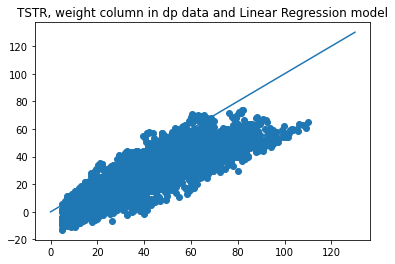

In [77]:
# example plot that does not loop through everything
plt.scatter(LR_dp_result['weight']['y_test'], LR_dp_result['weight']['y_pred'])
plt.plot([0,130],[0,130])
plt.title('TSTR, weight column in dp data and Linear Regression model')
#plt.savefig('png_files/3.1 DWP/TSTR_weight_dp0814_LR.png')
plt.show()

#### III) E Table

In [49]:
com_t = Comparison_Table(synthetic_num_dic, aver=True, models=['LR', 'KNR1'])
display(com_t)
#com_t.to_csv('csv_results/3.1 DWP/IIIE Table.csv')

DoppelGANger_0903              
                   ori           gen
LR        7.046777e+07  1.019312e+06
KNR1      7.996195e+07  6.766150e+05

In [16]:
def Scatter_TSTS_TRTR(E_table):
    """
    Plots the E values for training + testing on real data against training + testing on synthetic data
    Ideally, the points should lie on the diagonal y=x
    Args:
    E_table: df containing E values (usually generated from Comparison_Table function, with aver=True)
    """
    df_dic = list(set(E_table.keys().get_level_values(0).tolist()))
    models = (E_table.index).tolist()
    l = len(df_dic)
    for n in range(l):
        key = df_dic[n]
        plt.scatter(E_table[key,'ori'],E_table[key,'gen'],color='r')
        max_v = np.max(E_table[key,'ori'])
        plt.plot([0,max_v],[0,max_v])
        plt.xlabel('original')
        plt.ylabel('generated')
        plt.title(key)
        #plt.savefig('png_files/3.1 DWP/scatter from IIIE Table '+ key+'.png')
        plt.show()

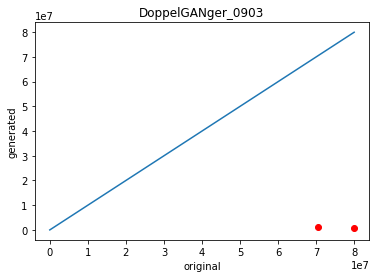

In [51]:
Scatter_TSTS_TRTR(com_t)

#### SRA Measuring E Table

In [17]:
def SRA_TSTS_TRTR(E_table):
    """
    SRA for table of E values
    """
    df_dic = list(set(E_table.keys().get_level_values(0).tolist()))
    models = (E_table.index).tolist()
    l = len(df_dic)
    v_np = np.zeros(l)
    for n in range(l):
        key = df_dic[n]
        v_np[n] = SRA(E_table[key,'ori'],E_table[key,'gen'])
    display('SRA for E table')
    return pd.Series(v_np,index = df_dic)

In [58]:
sra_E = SRA_TSTS_TRTR(com_t)
display(sra_E)
#sra_E.to_csv('csv_results/3.1 DWP/sra_E.csv')

'SRA for E table'

DoppelGANger_0903    0.0
dtype: float64

#### IV) SRA measuring the list of MSEs for each column predicition results, for the specified model and synthetic data generator

In [18]:
def SRA_Comparison(df_dic,models = ['LR','DTR','SVM','RFR','KNR1','KNR5'] ):
    '''
    The dataframe values are TSTSvsTRTR SRAs which are ranking values for the accuracy of every columns, for the index model which is trained and tested on the column dataset.
    '''
    l = len(df_dic)
    v_np = np.zeros((len(models),l))
    keys = list(df_dic.keys())
    for n in range(l):
        k = keys[n]
        P1 = Prediction(df_dic[k][0])
        P2 = Prediction(df_dic[k][1])
        for m in range(len(models)):
            model = models[m]
            v_np[m][n] = SRA(P1.Evaluation_MSE(model),P2.Evaluation_MSE(model))
    display('SRA for column rankings')
    return pd.DataFrame(v_np,index = models, columns = keys)

In [60]:
sra_c = SRA_Comparison(synthetic_num_dic, models=['LR','KNR1'])
display(sra_c)

'SRA for column rankings'

DoppelGANger_0903
LR             0.843137
KNR1           0.862745

#### V) Epsilon Values Table

In [64]:
def Epsilon_Table(df_dic, models=['LR','DTR','SVM','RFR','KNR1','KNR5'] ):
    '''
    The dataframe values are TSTSvsTRTR Epsilon values for the index model and column generator.
    '''
    
    l = len(df_dic)
    v_np = np.zeros((len(models),l))
    keys = list(df_dic.keys())
    for n in range(l):
        k = keys[n]
        P1 = Prediction(df_dic[k][0])
        P2 = Prediction(df_dic[k][1])
        column_length = len((df_dic[k][0].keys()).tolist())
        for m in range(len(models)):
            model = models[m]
            v_np[m][n] = mean_squared_error(P1.Evaluation_MSE(model),P2.Evaluation_MSE(model))/column_length
    display('Epsilon value table')
    return pd.DataFrame(v_np,index = models, columns = keys)

In [66]:
EpsilonTable = Epsilon_Table(synthetic_num_dic, models=['LR', 'KNR1'])
#EpsilonTable.to_csv('csv_results/3.1 DWP/EpsilonTable.csv')
display(EpsilonTable)

'Epsilon value table'

DoppelGANger_0903
LR         5.591554e+15
KNR1       7.775837e+15

### Time Predictive

In [88]:
def make_time_windows(dataset, w):
    """replaces each participant's 130 time-steps long timeseries with 
    all possible time series chunks of length w
    Args:
    dataset: 3d numpy array (num sample, max time series length, numerical column dimension) 
            containing only numerical columns from the dataset
    w: window length of time series

    """
    num_participants, full_length, _ = np.shape(dataset)
    time_windows = []

    for i in list(range(num_participants)): # i = participant's position in dataset

        for j in list(range(full_length-w+1)): # j = row number of first row in window
            time_windows.append(dataset[i,j:j+w,:])

    return np.stack(time_windows)


def make_x_y(dataset, y_index, w):
    """make inputs for model. Note the returned data's sequence length = w-1
        
        Args:
        dataset: 3d numpy array (num sample, max time series length, numerical column dimension) 
                containing only numerical columns from the dataset
        y_index: index of column to be treated as the 'label'
        w: window length of time series, should be less than time series length

        Returns:
        x: train data
        y: train label
    """
    dataset = make_time_windows(dataset, w)
    x = np.delete(dataset, obj=y_index, axis=2) # remove y column from all time series
    x = np.delete(x, obj=-1, axis=1) # remove last row from all time series
    y = dataset[:,1:,[y_index]] # take only y column and remove its earliest cell
    return x, y

In [89]:
def last_time_step_mae(Y_true, Y_pred):
    """
    calculates the MAE of the last time step
    """
    return tf.keras.metrics.MAE(Y_true[:, -1], Y_pred[:, -1])

def make_predictive_model(num_cols):
    input_size = [None,num_cols-1] 
    hidden_dim = num_cols//2 #

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_size)) # (#timesteps -1, #features=dim-1) 
    model.add(tf.keras.layers.GRU(hidden_dim, return_sequences=True)) # (#timesteps -1, hidden_dim)
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hidden_dim, activation = "sigmoid")))  # (#timesteps -1, hidden_dim)
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation = "linear")))  # (#timesteps -1, 1)

    model.compile(optimizer = "adam", loss = tf.keras.losses.MeanAbsoluteError(), metrics=[last_time_step_mae])

    return model

In [90]:
def predictive_train_test(train_set, test_set, y_cols='all', y_cols_name=num_cols, windows='max', val_ratio=0.2, batch_size=64, epochs=15, show_training=True):
    """ does the T_T_ portion of the scheme

    Args:
    - train_set, test_set: ori_data, gen_data in order of T_T_ (labels NOT yet split off), usually output from train_test_split
    Make sure train and test are disjoint!
    If doing TSTSvsTRTR then use this function twice
    - y_cols: list of columns to use as target
    - y_cols_name: the names of ALL the numerical columns
    - windows: list contains lengths of windows to be used in order of y columns
            NOTE length of input sequences is actually window_length - 1 because of make_x_y
    - val_ratio: validation set ratio split from train_set for use during training
    - batch_size
    - epochs

    Returns:
    - results_df: dataframe containing training results
    - histories
    """

    results = []
    histories = []
    _, max_window, num_columns = np.shape(train_set)
    
    #### for convenience when not tuning parameters
    if y_cols=='all':
        y_cols = list(range(num_columns))

    if windows=='max':
        windows=[max_window]*len(y_cols)
    elif isinstance(windows, int):
        windows=[windows]*len(y_cols)

    for k in range(len(y_cols)): # step 5 (repeating steps 2-4 for each column)
        print('\nPredictive model running for column ', str(y_cols_name[k]), ' with window length ', str(windows[k]))
        train_x, train_y = make_x_y(train_set, y_cols[k], windows[k]) # step 2
        test_x, test_y = make_x_y(test_set, y_cols[k], windows[k])
        train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=val_ratio)

        model = make_predictive_model(num_columns)
        hist = model.fit(np.asarray(train_x), np.asarray(train_y), batch_size=batch_size, epochs=epochs, validation_data=(val_x, val_y), verbose=0) # step 4
        print('Getting results for column ', str(y_cols_name[k]), ' with window length ', str(windows[k]))

        results.append([y_cols_name[k], windows[k], batch_size, epochs]+model.evaluate(test_x, test_y, batch_size=batch_size))
        histories.append(hist)

        if show_training:
            plt.plot(hist.history['loss'])
            plt.plot(hist.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train loss', 'val loss'], loc='upper right')
            plt.show()

    results_df = pd.DataFrame(results, columns=['y_col', 'window_length', 'batch_size', 'epochs', 'test_loss', 'test_metric'])

    return results_df, histories
        


#### TRTR vs TSTS example

In [92]:
train_ori_set, test_ori_set = train_test_split(ori_3d_num, train_size=0.5)
TRTR_results, TRTR_histories = predictive_train_test(train_ori_set, test_ori_set, y_cols=[0,1,2], windows=65, epochs=2, show_training=False)

train_gen_set, test_gen_set = train_test_split(gen_3d_num, train_size=0.5)
TSTS_results, TSTS_histories = predictive_train_test(train_gen_set, test_gen_set, y_cols=[0,1,2], windows=65, epochs=2, show_training=False)


Predictive model running for column  ab_pain_dur  with window length  65
Getting results for column  ab_pain_dur  with window length  65
696/696 [==============================] - 7s 9ms/step - loss: 0.0336 - last_time_step_mae: 0.0031

Predictive model running for column  age  with window length  65
Getting results for column  age  with window length  65
696/696 [==============================] - 7s 10ms/step - loss: 2.1160 - last_time_step_mae: 0.2386

Predictive model running for column  aneroxia_dur  with window length  65
Getting results for column  aneroxia_dur  with window length  65
696/696 [==============================] - 7s 9ms/step - loss: 0.0204 - last_time_step_mae: 0.0025

Predictive model running for column  ab_pain_dur  with window length  65
Getting results for column  ab_pain_dur  with window length  65
696/696 [==============================] - 6s 9ms/step - loss: 0.1146 - last_time_step_mae: 0.0139

Predictive model running for column  age  with window length  65

In [117]:
def get_TRTR_TSTS_results(TRTR_results, TSTS_results):
    TRTR_TSTS_combine = pd.merge(TRTR_results[['y_col', 'test_loss', 'test_metric']], TSTS_results[['y_col','test_loss', 'test_metric']], on='y_col')
    TRTR_TSTS_combine.columns = ['y_col', 'test_loss_real', 'test_metric_real', 'test_loss_syn', 'test_metric_syn']
    return TRTR_TSTS_combine

In [120]:
TxTx_tpred = get_TRTR_TSTS_results(TRTR_results, TSTS_results)
TxTx_tpred

y_col  test_loss_real  test_metric_real  test_loss_syn  \
0   ab_pain_dur        0.033642          0.003147       0.114644   
1           age        2.116048          0.238610       1.921224   
2  aneroxia_dur        0.020402          0.002459       0.086321   

   test_metric_syn  
0         0.013865  
1         0.219118  
2         0.010538

In [124]:
def get_TxTx_mse(TxTx_tpred):
    test_mse = mean_squared_error(TxTx_tpred['test_loss_real'], TxTx_tpred['test_loss_syn'])
    metric_mse = mean_squared_error(TxTx_tpred['test_metric_real'], TxTx_tpred['test_metric_syn'])
    df = pd.DataFrame([[test_mse, metric_mse]], columns=['test_loss', 'metric_loss'], index=['MSE'])
    return df
get_TxTx_mse(TxTx_tpred)

test_loss  metric_loss
MSE   0.016288     0.000187

In [126]:
def get_TxTx_SRA(TxTx_tpred):
    sra_test = SRA(TxTx_tpred['test_loss_real'], TxTx_tpred['test_loss_syn'])
    sra_metric = SRA(TxTx_tpred['test_metric_real'], TxTx_tpred['test_metric_syn'])
    df = pd.DataFrame([[sra_test, sra_metric]], columns=['test_loss', 'metric_loss'], index=['SRA'])
    return df
get_TxTx_SRA(TxTx_tpred)

test_loss  metric_loss
SRA        1.0          1.0

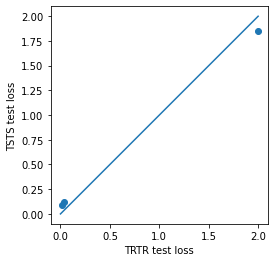

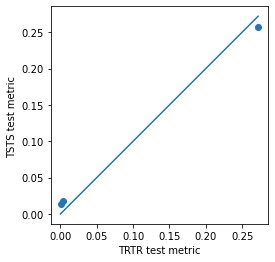

In [134]:
plt.scatter(TRTR_results['test_loss'], TSTS_results['test_loss'])
plt_max = max(max(TRTR_results['test_loss']), max(TSTS_results['test_loss']))
plt.plot([0,plt_max], [0, plt_max])
plt.xlabel('TRTR test loss')
plt.ylabel('TSTS test loss')
plt.axis('square')
plt.show()

plt.scatter(TRTR_results['test_metric'], TSTS_results['test_metric'])
plt_max = max(max(TRTR_results['test_metric']), max(TSTS_results['test_metric']))
plt.plot([0,plt_max], [0, plt_max])
plt.xlabel('TRTR test metric')
plt.ylabel('TSTS test metric ')
plt.axis('square')
plt.show()